In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [3]:
# Charger les données prétraitées
df = pd.read_csv("../preprocessing/preprocessed_timeseries.csv", parse_dates=True, index_col=0)

# S'assurer que l'index est une colonne de type datetime
df.index = pd.to_datetime(df.index)

# Identifier les colonnes cibles (toutes sauf la date)
target_columns = df.columns.tolist()

# Dictionnaire pour stocker les prédictions
forecast_results = {}


In [16]:
# create_features est essentielle pour transformer une série temporelle brute en un format exploitable par XGBoost
def create_features(df, column, lags=25):
    """
    Crée des features pour la colonne donnée :
    - Décalages temporels (lags)
    - Moyennes mobiles
    """
    data = df[[column]].copy()
    
    # Créer des lag features (valeurs passées)
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[column].shift(lag)


    # Détecter la fréquence
    detected_freq = pd.infer_freq(df.index)
    print("***",detected_freq,"***")
    if detected_freq in ["D", "B"]:  # Quotidienne ou Business Days
        rolling_windows = [7, 14, 30]
    elif detected_freq in ["MS", "M"]:  # Mensuelle
        rolling_windows = [3, 6, 12]
    elif detected_freq in ["YS", "Y"]:  # Annuelle
        rolling_windows = [2, 3, 5]
    else:
        pass

    # Appliquer les moyennes mobiles pour detecter la saisonnalité
    for window in rolling_windows:
        data[f'rolling_mean_{window}'] = data[column].shift(1).rolling(window=window).mean()

    # Supprimer les valeurs NaN générées par les décalages
    data.dropna(inplace=True)
    #data.to_csv("data3.csv")
    return data



Training XGBoost model for beer...
*** MS ***
MSE for beer: 0.1365


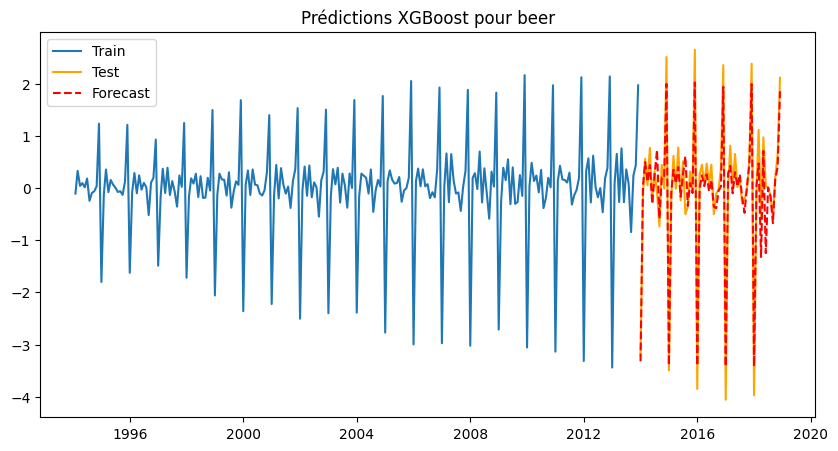

Toutes les prédictions XGBoost ont été enregistrées.


In [17]:
for column in target_columns:
    print(f"Training XGBoost model for {column}...")

    # Créer les features
    data = create_features(df, column)

    # Séparer les features (X) et la cible (y)
    X = data.drop(columns=[column])
    y = data[column]

    # Séparer Train/Test (80% - 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Entraîner le modèle XGBoost
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Faire des prédictions
    y_pred = model.predict(X_test)

    # Calculer l'erreur
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE for {column}: {mse:.4f}")

    # Sauvegarder les résultats
    forecast_results[column] = pd.DataFrame({"ds": X_test.index, "yhat": y_pred})

    # Visualisation
    plt.figure(figsize=(10, 5))
    plt.plot(y_train.index, y_train, label="Train")
    plt.plot(y_test.index, y_test, label="Test", color="orange")
    plt.plot(y_test.index, y_pred, label="Forecast", linestyle="dashed", color="red")
    plt.title(f"Prédictions XGBoost pour {column}")
    plt.legend()
    plt.show()

# Sauvegarder les prévisions
for col, forecast in forecast_results.items():
    forecast.to_csv(f"forecast_xgboost_{col}.csv", index=False)

print("Toutes les prédictions XGBoost ont été enregistrées.")
